<a href="https://colab.research.google.com/github/m0421/pytorch/blob/main/CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torchvision import datasets, transforms, models


import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

rng = np.random.RandomState(1234)
random_state=42

In [ ]:
batch_size=1 
dataloader_train = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data/cifar10', 
                     train=True, 
                     download=True, 
                     transform=transforms.ToTensor()
                     ),
    batch_size=batch_size,
    shuffle=False
)


Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10


**画像を可視化**

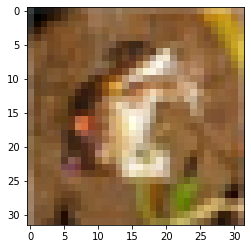

In [ ]:
import torchvision #画像処理を手軽に行うためのライブラリ
import matplotlib.pyplot as plt
def imshow(img):
    img = torchvision.utils.make_grid(img)
    #detach コピー機能 メモリは共有されているのでコピー元も影響を受ける
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (2,1,0)))
    plt.show()
    
iterator=dataloader_train.__iter__()
#iterator = iter(dataloader_train)  #こっちの書き方でもいける
x, _ = next(iterator)
imshow(x)

**前処理**

**GCN**


In [ ]:
class gcn():
    def __init__(self):
        pass
    def __call__(self, x):
        mean = torch.mean(x)
        std = torch.std(x)
        return (x - mean)/(std + 10**(-6))  # 0除算を防ぐ


def deprocess(x):
    _min = np.min(x)
    _max = np.max(x)
    _x = (x - _min)/(_max - _min)
    return _x

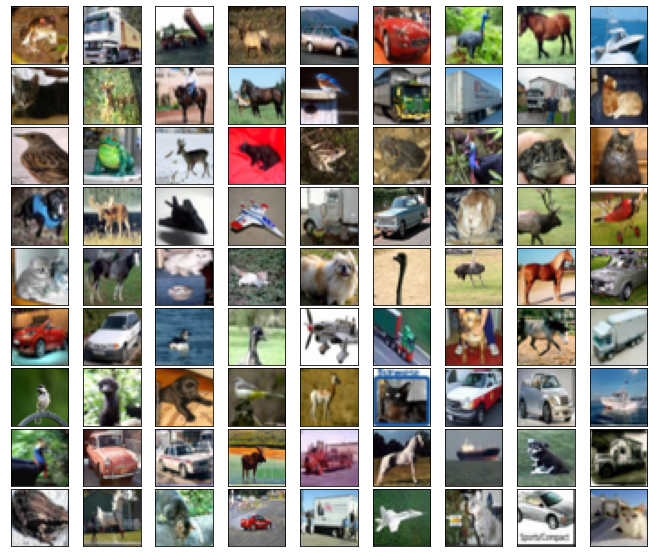

In [ ]:
GCN = gcn()
transform_GCN = transforms.Compose([transforms.ToTensor(),GCN])

dataloader_train_gcn = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data/cifar10', 
                     train=True, 
                     transform=transform_GCN #ここで処理(gcnを含む)を行う
                     ),
    batch_size=batch_size,
    shuffle=False
)

#可視化
fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,wspace=0.05)

i = 0
for x, _ in dataloader_train_gcn:
    x = np.transpose(torch.squeeze(x).numpy(), (1, 2, 0))
    ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(deprocess(x))
    i += 1
    if i >= 81:
        break

**ZCA白色化**



In [ ]:
class ZCAWhitening():
    def __init__(self, epsilon=1e-4, device="cuda"):  # 計算が重いのでGPUを用いる
        self.epsilon = epsilon
        self.device = device

    def fit(self, images):  # 変換行列と平均をデータから計算
        x = images[0][0].reshape(1, -1)
        self.mean = torch.zeros([1, x.size()[1]]).to(self.device)
        con_matrix = torch.zeros([x.size()[1], x.size()[1]]).to(self.device)
        for i in range(len(images)):  # 各データについての平均を取る
            x = images[i][0].reshape(1, -1).to(self.device)
            self.mean += x / len(images)
            con_matrix += torch.mm(x.t(), x) / len(images)
            if i % 10000 == 0:
                print("{0}/{1}".format(i, len(images)))
        con_matrix -= torch.mm(self.mean.t(), self.mean)
        E, V = torch.symeig(con_matrix, eigenvectors=True)  # 固有値分解
        self.ZCA_matrix = torch.mm(torch.mm(V, torch.diag((E.squeeze()+self.epsilon)**(-0.5))), V.t())
        print("completed!")

    def __call__(self, x):
        size = x.size()
        x = x.reshape(1, -1).to(self.device)
        x -= self.mean
        #print(x)
        x = torch.mm(x, self.ZCA_matrix.t())
        #print(x)
        x = x.reshape(tuple(size))
        x = x.to("cpu")
        return x   
      

0/50000
10000/50000
20000/50000
30000/50000
40000/50000
completed!


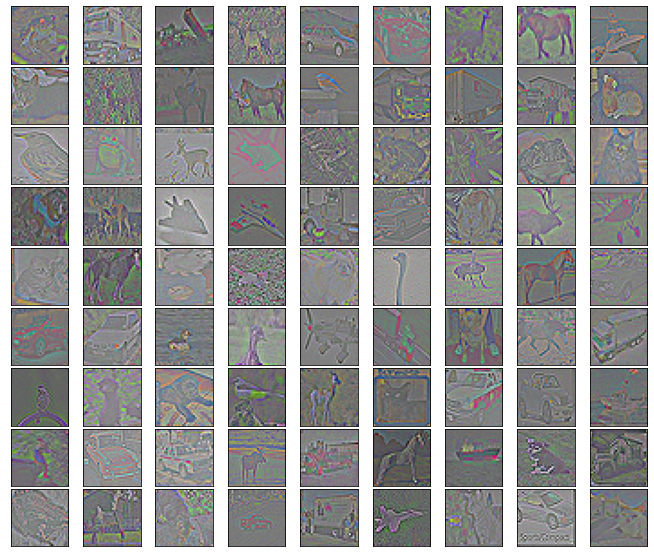

In [ ]:
zca = ZCAWhitening()
images = datasets.CIFAR10('./data/cifar10', 
                          train=True, 
                          transform=transforms.ToTensor()
                          )
zca.fit(images) #学習

transform_zca = transforms.Compose([transforms.ToTensor(),zca])

dataloader_train_zca=torch.utils.data.DataLoader(
    datasets.CIFAR10('./data/cifar10', 
                     train=True, 
                     transform=transform_zca #学習させたzca白色化モデルを適用
                     ),
    batch_size=batch_size,
    shuffle=False
)
#可視化
fig=plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,wspace=0.05)
i = 0
for x, _ in dataloader_train_zca:
    x = np.transpose(torch.squeeze(x).numpy(), (1, 2, 0))
    ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(deprocess(x))
    i += 1
    if i >= 81:
        break

**ネットワークを実装**

In [ ]:
#nn.Conv2d(入力チャンネル数,出力チャンネル数,stride数)
conv_net=nn.Sequential(
    nn.Conv2d(3, 32, 3),              # 32x32x3->30x30x32
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.AvgPool2d(2),                  # 30x30x32->15x15x32
    nn.Conv2d(32, 64, 3),             # 15x15x32->13x13x64
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.AvgPool2d(2),                  # 13x13x64->6x6x64
    nn.Conv2d(64, 128, 3),            # 6x6x64->4x4x128
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.AvgPool2d(2),                  # 4x4x128->2x2x128 
    nn.Flatten(), #平滑化
    nn.Linear(2*2*128, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

#重みの初期化
def init_weights(m): 
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.0)

conv_net.apply(init_weights)

batch_size=100 #バッチサイズ
n_epochs=5 #エポック数
lr=0.01 #学習率
device='cuda'

conv_net.to(device)　#ネットワークをgpuに移動　
optimizer=optim.Adam(conv_net.parameters(), lr=lr) #パラメータ更新
loss_function = nn.CrossEntropyLoss()  #損失関数
#nn.ClossEntropyLossは、出力のsoftmax変換と、正解ラベルのone-hot vector化の機能を持っている

**学習に使うデータを読み込み前処理を施す**

In [ ]:
trainval_dataset = datasets.CIFAR10('./data/cifar10', train=True, transform=transforms.ToTensor())

#zca白色化を定義
zca = ZCAWhitening()
zca.fit(trainval_dataset)

# 前処理を定義
transform = transforms.Compose([transforms.ToTensor(),zca])

trainval_dataset = datasets.CIFAR10('./data/cifar10', train=True, transform=transform)

# trainとvalidに分割
train_dataset,val_dataset=torch.utils.data.random_split(trainval_dataset,[len(trainval_dataset)-10000, 10000])

#ここでdataloaderに入れることで勝手にミニバッチに分けてくれる
dataloader_train=torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
dataloader_valid=torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True
)

0/50000
10000/50000
20000/50000
30000/50000
40000/50000
completed!


**学習**

In [ ]:
for epoch in range(n_epochs):
    losses_train = []
    losses_valid = []

    conv_net.train() #学習モードに設定
    n_train = 0
    acc_train = 0
    for x, t in dataloader_train:
        n_train += t.size()[0]
        conv_net.zero_grad()  # 勾配の初期化
        x = x.to(device)  # テンソルをGPUに移動
        t = t.to(device) 
        y = conv_net.forward(x)  # 順伝播
        loss = loss_function(y, t)  # 誤差(クロスエントロピー誤差関数)の計算
        loss.backward()  # 誤差の逆伝播
        optimizer.step()  # パラメータの更新
        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする
        acc_train += (pred == t).float().sum().item()
        losses_train.append(loss.tolist())

    conv_net.eval() #評価モードに設定
    n_val = 0
    acc_val = 0
    for x, t in dataloader_valid:
        n_val += t.size()[0]
        x = x.to(device)  # テンソルをGPUに移動
        t = t.to(device)
        y = conv_net.forward(x)  # 順伝播
        loss = loss_function(y, t)  # 誤差(クロスエントロピー誤差関数)の計算
        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする
        acc_val += (pred == t).float().sum().item()
        losses_valid.append(loss.tolist())

    print('EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]'.format(
        epoch,
        np.mean(losses_train),
        acc_train/n_train,
        np.mean(losses_valid),
        acc_val/n_val
    ))

EPOCH: 0, Train [Loss: 1.335, Accuracy: 0.534], Valid [Loss: 1.139, Accuracy: 0.604]
EPOCH: 1, Train [Loss: 0.854, Accuracy: 0.703], Valid [Loss: 0.868, Accuracy: 0.700]
EPOCH: 2, Train [Loss: 0.694, Accuracy: 0.759], Valid [Loss: 0.774, Accuracy: 0.734]
EPOCH: 3, Train [Loss: 0.596, Accuracy: 0.795], Valid [Loss: 0.782, Accuracy: 0.735]
EPOCH: 4, Train [Loss: 0.517, Accuracy: 0.823], Valid [Loss: 0.725, Accuracy: 0.759]


**Activationの可視化**

In [ ]:
class Activation():
  #初期化
  def __init__(self,image_id): #image_id: 表示させる画像id
    self.image_id=image_id
    self.trainval=datasets.CIFAR10('./data/cifar10') #データセットをダウンロード 今回はcifar10

  #元画像の可視化
  def show(self):
    sample_image=trainval[image_id][0]
    plt.imshow(sample_image)

  #output_layer番目の層の特徴マップを出力する関数
  def feature_map(self,image, output_layer): 
      image = transform(image)
      image = conv_net[0:output_layer + 1](image.unsqueeze(0).to(device))
      return image
  
  #activationを可視化する関数 k:可視化する段階
  def activation_visualization(self,k):
    _output = feature_map(sample_image, k).to("cpu")
    fig = plt.figure(figsize=(10, 10))
    _output = np.transpose(torch.squeeze(_output).detach().numpy(), (1, 2, 0))
    for i in range(3):
        ax = fig.add_subplot(1, 3, i+1, xticks=[], yticks=[])
        ax.imshow(deprocess(_output[:, :, i]), cmap='gray')
 
 #ネットワークの全体構造をみたい場合は print(conv_net)で出てくるから
 


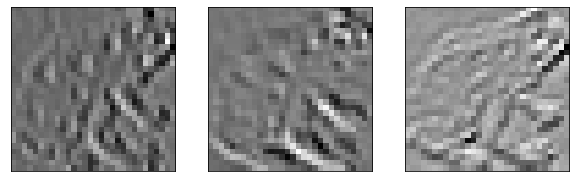

In [ ]:
L=Activation(920)
L.activation_visualization(0)